# Simulated data

- Input time series are taken from Lugano.

- Streamflow time series have been obtained by running the threebox model with parameters to obtain the damped, base and flashy cases.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
path = '../../data/simulated_data/hourly_data_withPET/'

In [2]:
ls_stations = ['base', 'flashy', 'damped']

In [3]:
def show_data(df, max_time_points=24*365, title=None):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    precipitation = df['p'][-max_time_points:]
    dates = df['t'][-max_time_points:]
    pet = df['pet'][-max_time_points:]
    streamflow = df['q'][-max_time_points:]
    # Plot precipitation with inverted y-axis on the first axis
    ax1.plot(dates, precipitation, color='blue', alpha=0.6, label='Precipitation')
    ax1.invert_yaxis()  # Invert the y-axis to make precipitation start from the top
    ax1.set_ylabel('Precipitation (mm)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xlabel('Date')
    
    # Create a second y-axis for PET
    ax2 = ax1.twinx()
    ax2.plot(dates, pet, color='green', label='PET')
    
    ax2.plot(dates, streamflow, color='orange', label='Streamflow')
    # Add a legend to the plot
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
        
    # Adjust layout to avoid overlap
    fig.tight_layout()
    if not(title is None):
        plt.title(title)
    # Display the plot
    plt.show()

In [4]:
def show_transfer_functions(pathsite, data, site, max_lag=24*3, title=None, K=4):
    tfs = np.load(os.path.join(pathsite, 'transfer.npy'))
    plt.figure(1)
    plt.plot([i/24 for i in range(max_lag)], np.mean(tfs, axis=0)[:max_lag])
    plt.xlabel('Lag (in Days)', fontsize=14)
    plt.ylabel('Global NRF', fontsize=14)
    if not(title is None):
        plt.title(title, fontsize=14)
    plt.show()

    lst_tfs = np.load(os.path.join(pathsite, 'lst_transfer.npy'))[:tfs.shape[0]]
    precipitation = data['p'].iloc[np.array([el-1 for el in lst_tfs])] # -1 since the index have been saved from R where indexes start at 1 and not 0 as in python
    n = len(precipitation)
    sorted_precip = np.sort(precipitation)
    low = np.min(sorted_precip)
    precip_ranges = []
    for k in range(K):
        up = sorted_precip[min(int(n * (k+1)/K), n-1)]
        precip_ranges.append([low,up])
        low = up

    colors = ['red', 'orange', 'cyan', 'blue']
    plt.figure(2)
    for k in range(K):
        low,up = precip_ranges[k]
        idxs = np.where((low<=precipitation) & (precipitation<up))[0]
        average_tf = np.mean(tfs[idxs,:], axis=0)
        if k==K-1:
            up = 'max'
        plt.plot([i/24 for i in range(max_lag)], average_tf[:max_lag], label='{0}-{1}'.format(low,up), c=colors[k])
    plt.legend(title='Precipitation range')
    plt.xlabel('Lag (in Days)', fontsize=14)
    plt.ylabel('NRF startified by precipitation intensity', fontsize=14)
    if not(title is None):
        plt.title(title, fontsize=14)
    plt.show()

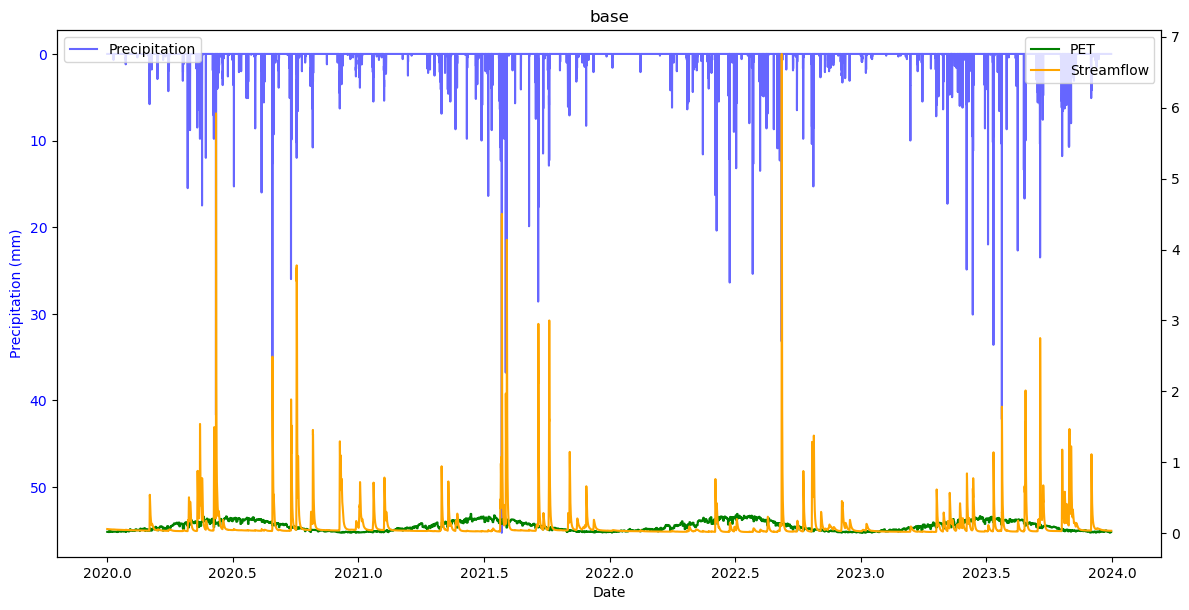

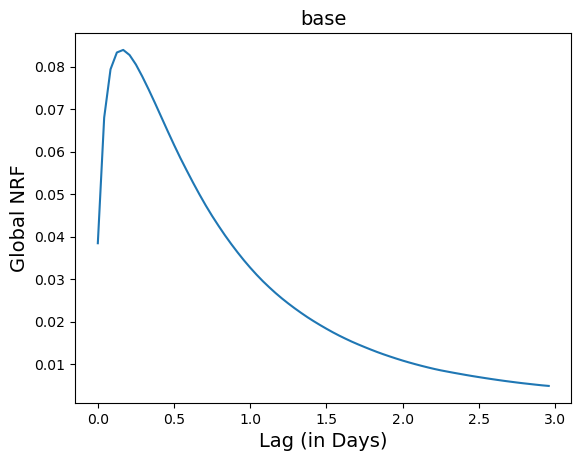

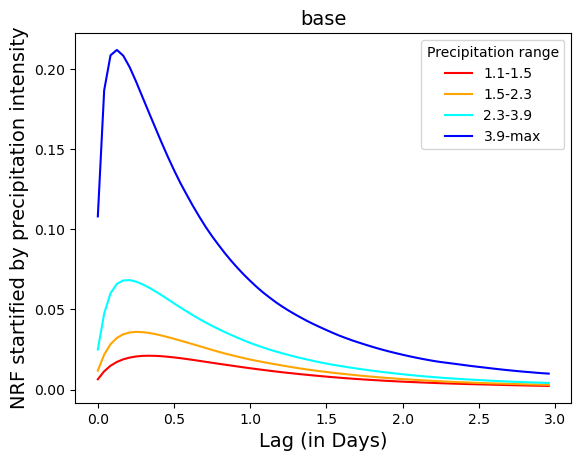

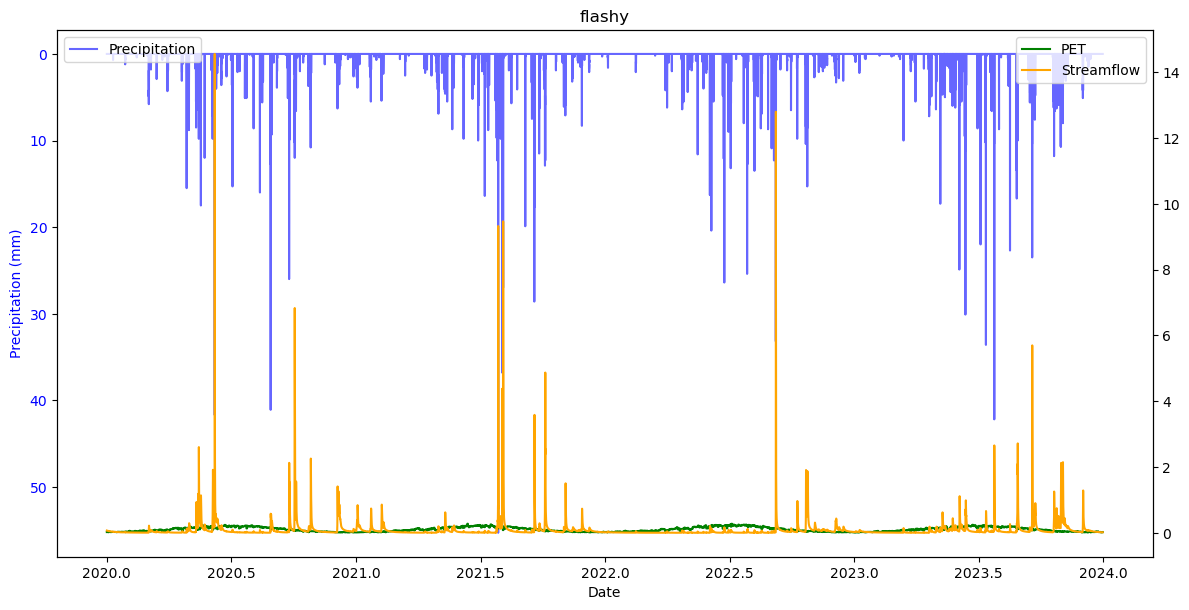

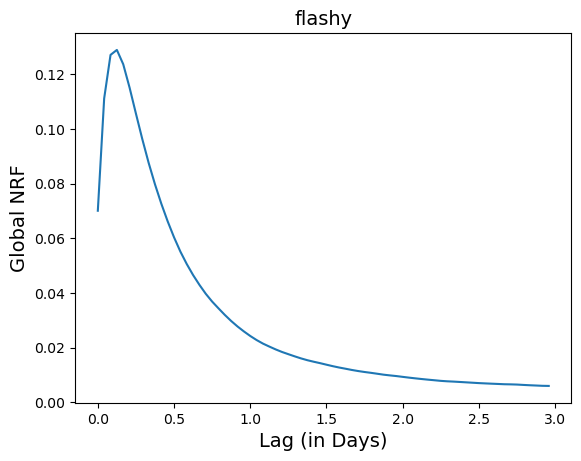

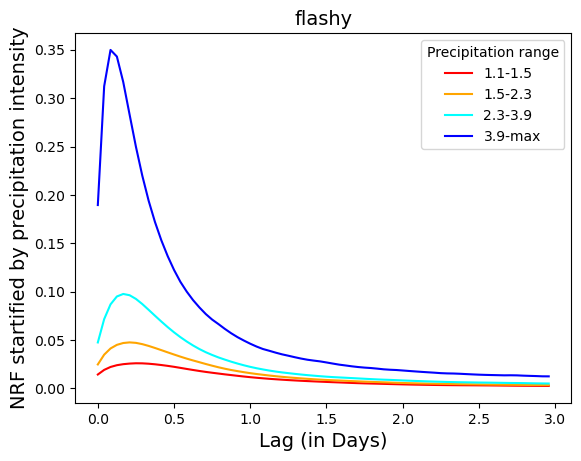

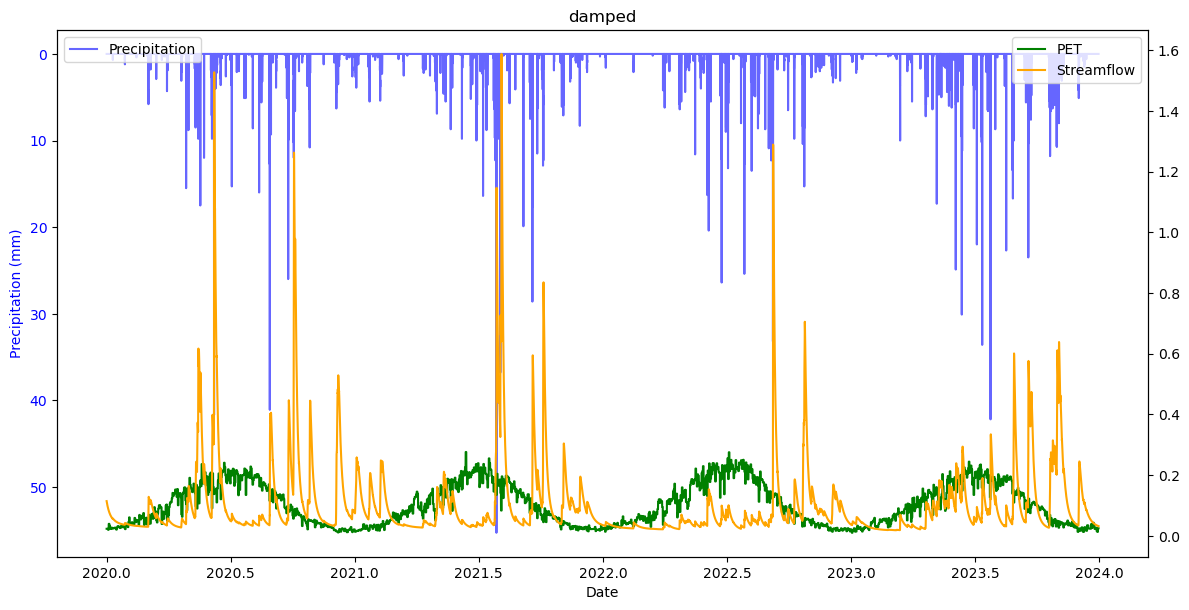

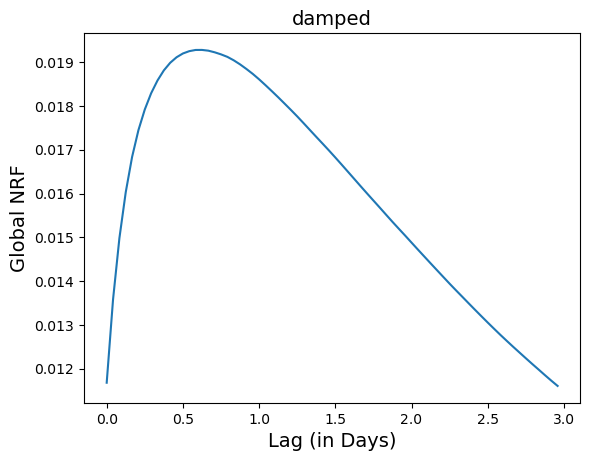

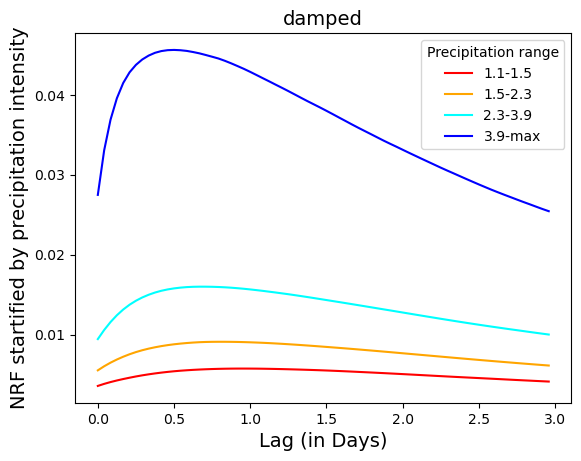

In [5]:
for site in ls_stations:
    pathsite = os.path.join(path, site)
    data = pd.read_csv(os.path.join(pathsite, 'data_{0}.txt'.format(site)))
    try:
        data.rename(columns={"timeyear": "t"}, inplace=True)
    except:
        pass
    show_data(data, max_time_points=24*365*4, title=site)
    show_transfer_functions(pathsite, data, site, max_lag=24*3, title=site)